In [1]:
from torch import nn, optim
import numpy as np
import pickle as p
import torch
from tqdm.notebook import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataset import SleepDataset
from model import ConvNet
import utils
import os
USE_NNPACK=0

# Training Loop
The training loop is a very standard PyTorch training loop.

In [19]:
# function for training and evaluation
def train(model, num_epochs, train_dataloader, val_dataloader, criterion):
    losses_train = []
    accuracies_train = []
    f1s_train = []
    losses_val = []
    accuracies_val = []
    f1s_val = []

    for epoch in trange(num_epochs, unit="epochs"):

        # training
        running_loss = 0.0
        running_accuracy = 0.0
        conf_mat = torch.zeros(5, 5)

        model.train()

        for input, target in train_dataloader:

            target = target.long()
            optimizer.zero_grad()

            output = model(input)
            
            loss = criterion(output, target)
            loss.backward()

            running_loss += loss.item()
            conf_mat += utils.confusion_mat(output, target)

            prediction = torch.argmax(output, dim=1)


            for p, t in zip(prediction, target):
                if p == t:
                    running_accuracy+=1 
            #running_f1 += f1_score(target, prediction, average='macro')
            optimizer.step()


        running_loss /= (len(train_dataloader)*batch_size)
        running_accuracy /= (len(train_dataloader) * batch_size)
        f1 = utils.f1_score(conf_mat)

        losses_train.append(running_loss)
        accuracies_train.append(running_accuracy)
        f1s_train.append(f1)

        # output
        if epoch % 20 == 0:
            tqdm.write('Epoch {} (train) -- loss: {:.2f} acc: {:.2f}'.format(epoch, running_loss, running_accuracy))


        # validation
        with torch.no_grad():

            model.eval()

            running_loss = 0.0
            running_accuracy = 0.0
            conf_mat = torch.zeros(5, 5)

            for input, target in val_dataloader:

                    target = target.long()
                    output = model(input)
                    loss = criterion(output, target)
                     
                    running_loss += loss.item()
                    conf_mat += utils.confusion_mat(output, target)

                    prediction = torch.argmax(output, dim=1).float()   

                    for o, t in zip(prediction, target):
                        if o == t:
                            running_accuracy+=1 
                    #running_f1 += f1_score(target, prediction)

            running_loss /= (len(val_dataloader)*batch_size)
            running_accuracy /= (len(val_dataloader)*batch_size)
            f1 = utils.f1_score(conf_mat)

            scheduler.step(running_loss)

            losses_val.append(running_loss)
            accuracies_val.append(running_accuracy)
            f1s_val.append(f1)

            # output
            if epoch % 20 == 0:
                tqdm.write('Epoch {} (valid) -- loss: {:.2f} acc: {:.2f}, f1: {:.2f}'.format(epoch, running_loss, running_accuracy, f1))
    # make model callable outside this function
    train.trained_model = model
    train.losses_train = losses_train
    train.losses_val = losses_val
    train.accuracy_train = accuracies_train
    train.accuracy_val = accuracies_val
    train.f1_train = f1s_train
    train.f1_val = f1s_val

In [3]:
# load data and label files
# shape = [2284, 200, 3, 9] --> [datasets, time series, channels, devices]
data = p.load(open(r"data.pkl", "rb"))
labels = p.load(open(r"labels.pkl", "rb"))

data_aug = p.load(open(r"data_aug.pkl", "rb"))
labels_aug = p.load(open(r"labels_aug.pkl", "rb"))
print(data.shape)
print(data_aug.shape)

(5455, 11, 300)
(6364, 11, 300)


In [20]:
# create datasets
batch_size = 10

train_dataset = SleepDataset(data[1091:, ...], labels[1091:, ...], train=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SleepDataset(data[1091:, ...], labels[1091:, ...], train=False)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

train_dataset_aug = SleepDataset(data_aug[1091:, ...], labels_aug[1091::, ...], train=True)
train_dataloader_aug = DataLoader(dataset=train_dataset_aug, batch_size=batch_size, shuffle=True)

val_dataset_aug = SleepDataset(data_aug[1091:,...], labels_aug[1091:,...], train=False)
val_dataloader_aug = DataLoader(dataset=val_dataset_aug, batch_size=batch_size, shuffle=False)

print(len(train_dataset_aug))

4218


In [5]:
label_counts = torch.from_numpy(labels).bincount().float()
print(label_counts)
weights = np.sqrt(1/label_counts)
weights /= weights.mean()
print(weights)

tensor([1023., 1004.,  303., 1709., 1416.])
tensor([0.9140, 0.9226, 1.6794, 0.7071, 0.7769])


In [6]:
# define loss, optimizer etc.
model = ConvNet()
epochs = 100
lr = 0.001
criterion_weight = nn.CrossEntropyLoss(weight=weights.double())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.5)

load_model = False
#net_num = 1
#load pretrained model (to continue training)
#if load_model:
 #   model.load_state_dict(torch.load("trained_models/" + str(net_name) + ".pt"))

## Training without augmentation

### Non-weighted loss

In [9]:
# train model
train(model.double(), epochs, train_dataloader, val_dataloader, criterion=criterion)

  0%|          | 0/100 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.15 acc: 0.36
Epoch 0 (valid) -- loss: 0.14 acc: 0.39, f1: 0.29
Epoch 20 (train) -- loss: 0.10 acc: 0.63
Epoch 20 (valid) -- loss: 0.11 acc: 0.61, f1: 0.60
Epoch 40 (train) -- loss: 0.06 acc: 0.79
Epoch 40 (valid) -- loss: 0.09 acc: 0.73, f1: 0.74
Epoch 60 (train) -- loss: 0.04 acc: 0.85
Epoch 60 (valid) -- loss: 0.09 acc: 0.78, f1: 0.78
Epoch 80 (train) -- loss: 0.03 acc: 0.89
Epoch 80 (valid) -- loss: 0.10 acc: 0.80, f1: 0.80


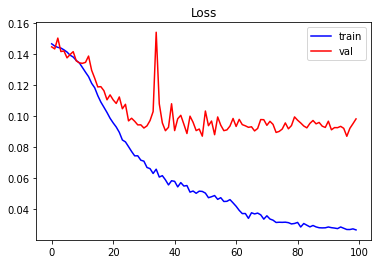

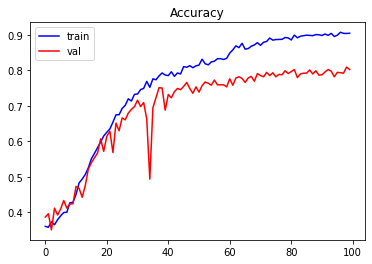

In [10]:
# plot metrics

# loss
plt.plot(np.arange(epochs), train.losses_train, color="b", label="train")
plt.plot(np.arange(epochs), train.losses_val, color="r", label="val")
plt.title("Loss")
plt.legend()
plt.show()

# accuracy
plt.plot(np.arange(epochs), train.accuracy_train, color="b",label="train" )
plt.plot(np.arange(epochs), train.accuracy_val, color="r",label="val")
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
# save model
torch.save(train.trained_model.state_dict(), "trained_models/" + "net_" + str(len(os.listdir("trained_models/"))) + ".pt")

### Weighted loss

In [24]:
# define loss, optimizer etc.
model = ConvNet()
epochs = 100
lr = 0.001
criterion_weight = nn.CrossEntropyLoss(weight=weights.double())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.5)

# train model
train(model.double(), epochs, train_dataloader, val_dataloader, criterion=criterion_weight)

  0%|          | 0/100 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.15 acc: 0.32
Epoch 0 (valid) -- loss: 0.17 acc: 0.34, f1: 0.25
Epoch 20 (train) -- loss: 0.11 acc: 0.54
Epoch 20 (valid) -- loss: 0.13 acc: 0.49, f1: 0.51
Epoch 40 (train) -- loss: 0.06 acc: 0.76
Epoch 40 (valid) -- loss: 0.12 acc: 0.71, f1: 0.71
Epoch 60 (train) -- loss: 0.05 acc: 0.81
Epoch 60 (valid) -- loss: 0.11 acc: 0.74, f1: 0.74
Epoch 80 (train) -- loss: 0.03 acc: 0.87
Epoch 80 (valid) -- loss: 0.10 acc: 0.77, f1: 0.77


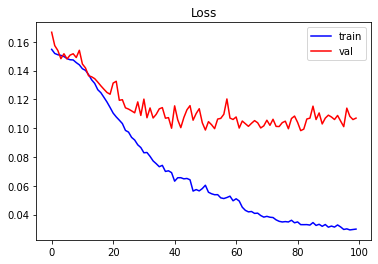

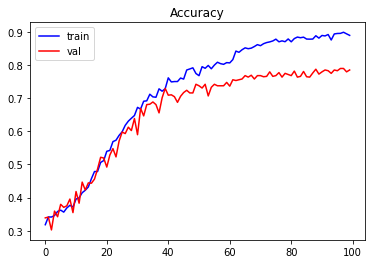

In [25]:
# plot metrics

# loss
plt.plot(np.arange(epochs), train.losses_train, color="b", label="train")
plt.plot(np.arange(epochs), train.losses_val, color="r", label="val")
plt.title("Loss")
plt.legend()
plt.show()

# accuracy
plt.plot(np.arange(epochs), train.accuracy_train, color="b",label="train" )
plt.plot(np.arange(epochs), train.accuracy_val, color="r",label="val")
plt.title("Accuracy")
plt.legend()
plt.show()

In [26]:
# save model
torch.save(train.trained_model.state_dict(), "trained_models/" + "net_" + "weighted_" + str(len(os.listdir("trained_models/"))) + ".pt")

## Training with augmentation

### Non-weighted loss

In [27]:
# define loss, optimizer etc.
model = ConvNet()
epochs = 100
lr = 0.001
criterion_weight = nn.CrossEntropyLoss(weight=weights.double())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.5)

train(model.double(), epochs, train_dataloader_aug, val_dataloader_aug, criterion=criterion)

  0%|          | 0/100 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.16 acc: 0.28
Epoch 0 (valid) -- loss: 0.16 acc: 0.33, f1: 0.31
Epoch 20 (train) -- loss: 0.09 acc: 0.64
Epoch 20 (valid) -- loss: 0.09 acc: 0.63, f1: 0.63
Epoch 40 (train) -- loss: 0.05 acc: 0.79
Epoch 40 (valid) -- loss: 0.09 acc: 0.71, f1: 0.71
Epoch 60 (train) -- loss: 0.04 acc: 0.85
Epoch 60 (valid) -- loss: 0.08 acc: 0.80, f1: 0.80
Epoch 80 (train) -- loss: 0.03 acc: 0.90
Epoch 80 (valid) -- loss: 0.08 acc: 0.82, f1: 0.82


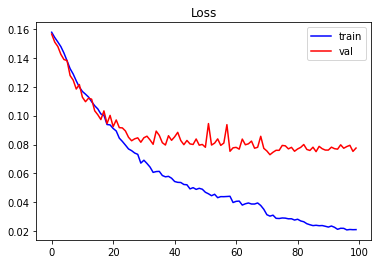

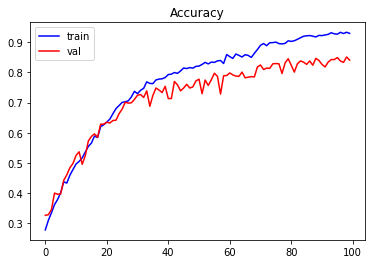

In [28]:
# plot metrics

# loss
plt.plot(np.arange(epochs), train.losses_train, color="b", label="train")
plt.plot(np.arange(epochs), train.losses_val, color="r", label="val")
plt.title("Loss")
plt.legend()
plt.show()

# accuracy
plt.plot(np.arange(epochs), train.accuracy_train, color="b",label="train" )
plt.plot(np.arange(epochs), train.accuracy_val, color="r",label="val")
plt.title("Accuracy")
plt.legend()
plt.show()

In [29]:
# save model
torch.save(train.trained_model.state_dict(), "trained_models/" + "net_aug" + str(len(os.listdir("trained_models/"))) + ".pt")

### Weighted loss

In [30]:
# define loss, optimizer etc.
model = ConvNet()
epochs = 100
lr = 0.001
criterion_weight = nn.CrossEntropyLoss(weight=weights.double())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.5)

train(model.double(), epochs, train_dataloader_aug, val_dataloader_aug, criterion=criterion_weight)

  0%|          | 0/100 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.15 acc: 0.25
Epoch 0 (valid) -- loss: 0.16 acc: 0.29, f1: 0.23
Epoch 20 (train) -- loss: 0.08 acc: 0.60
Epoch 20 (valid) -- loss: 0.08 acc: 0.62, f1: 0.60
Epoch 40 (train) -- loss: 0.05 acc: 0.77
Epoch 40 (valid) -- loss: 0.08 acc: 0.72, f1: 0.71
Epoch 60 (train) -- loss: 0.03 acc: 0.87
Epoch 60 (valid) -- loss: 0.06 acc: 0.80, f1: 0.80
Epoch 80 (train) -- loss: 0.02 acc: 0.91
Epoch 80 (valid) -- loss: 0.07 acc: 0.83, f1: 0.83


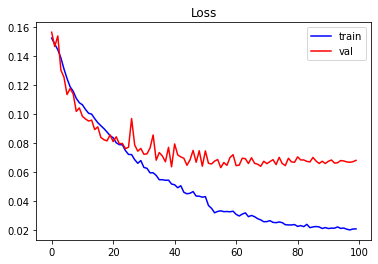

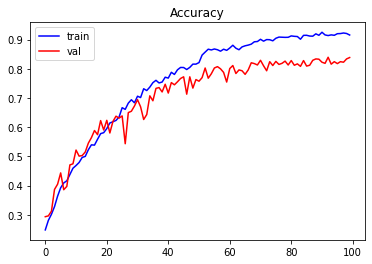

In [31]:
# plot metrics

# loss
plt.plot(np.arange(epochs), train.losses_train, color="b", label="train")
plt.plot(np.arange(epochs), train.losses_val, color="r", label="val")
plt.title("Loss")
plt.legend()
plt.show()

# accuracy
plt.plot(np.arange(epochs), train.accuracy_train, color="b",label="train" )
plt.plot(np.arange(epochs), train.accuracy_val, color="r",label="val")
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
# save model
torch.save(train.trained_model.state_dict(), "trained_models/" + "net_aug_weighted" + str(len(os.listdir("trained_models/"))) + ".pt")